# Half-hourly forward prices

***Terminology***: <br>
1. *Day-ahead price*: the price set in the wholesale market for electricity to be delivered on the next day.<br>
2. *Forward price*: the agreed-upon prices for electricty to be delivered at a future date, e.g. month-ahead or Sep 2025.  

***Purpose***: Simulate forward prices for the electricity market with half-hourly granularity and provide a detailed methodology to ensure traceability and maintainability. This enables UrbanChain to achieve more accurate pricing and minimize exposure to market volatility. <br><br>
***Data Sources***: <br>Day-ahead prices are available on the Energy Market Price ([EMP](https://www.energymarketprice.com/home/en/)) , updated daily.<br>Daily forward prices are available on the Intercontinental Exchange ([ICE](https://www.ice.com/report/10)) as UK Peak and Base electricity (Gregorian), also known as UPL and UBL. The peak period for demand is defined as 07:00 - 19:00 LLT Monday - Friday. <br><br>
***Methodologies***: We can use the day-ahead prices to simulate the volatility of the forward price curve. We would need half-hourly ***scalers*** to determine the weight for each half-hourly price compared to the monthly average, calculated as follows: $$\text{Scaler} = \frac{\text{Half-hourly price}}{\text{Monthly average}}$$<br> Once we have these half-hourly scalers, we can apply them to the baseload forward price for that month and produce half-hourly forward prices.

# Data Transformation

To simulate volatility effectively, we need to understand the underlying patterns of the day-ahead prices.

In [14]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import datetime
from dateutil.relativedelta import relativedelta

from datetime import timedelta
import calendar

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [15]:
# Importing the dataset with the latest day-ahead
day_ahead_sip = pd.read_excel(r"C:\Users\ThomasChow\URBANCHAIN LTD\Shared Materials - Materials\Portfolio Optimisation\Price data\Day-ahead vs system imbalance prices.xlsx")
day_ahead_sip = day_ahead_sip.iloc[:,0:3]
day_ahead_sip = day_ahead_sip.rename(columns = {'Spot Price': 'Day-ahead price'})

In [16]:
df = day_ahead_sip.copy()
df.head()

,Date (UTC),Time (UTC),Day-ahead price
0,2022-05-31,21:00:00,182.0
1,2022-05-31,21:30:00,138.0
2,2022-05-31,22:00:00,182.0
3,2022-05-31,22:30:00,138.0
4,2022-05-31,23:00:00,142.0


In [17]:
df['Date (UTC)'] = pd.to_datetime(df['Date (UTC)']).dt.date
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'].astype(str), errors='coerce').dt.time


As observed, there are abnormal jumps before 2023. As it is a stochastic process, we should only consider the latest year, e.g. Sep 2023-24

In [18]:
today = df['Date (UTC)'].iloc[-1]
last_year = today - relativedelta(years = 1) + relativedelta(days = 1)

In [19]:
df = df[(df['Date (UTC)'] <= today) & (df['Date (UTC)'] >= last_year)].reset_index(drop = True)
print(df)

       Date (UTC) Time (UTC)  Day-ahead price
0      2023-12-18   00:00:00            49.00
1      2023-12-18   00:30:00            64.70
2      2023-12-18   01:00:00            64.70
3      2023-12-18   01:30:00            51.90
4      2023-12-18   02:00:00            50.90
...           ...        ...              ...
17532  2024-12-17   06:00:00            93.39
17533  2024-12-17   06:30:00            89.00
17534  2024-12-17   07:00:00            84.50
17535  2024-12-17   07:30:00           106.51
17536  2024-12-17   08:00:00            95.10

[17537 rows x 3 columns]


In [20]:
df = df[(df['Date (UTC)'] <= today) & (df['Date (UTC)'] >= last_year)].reset_index(drop = True)
df['Peak'] = df['Time (UTC)'].apply(lambda x: 'peak' if x > datetime.time(6,30,0) and x < datetime.time(19,30,0) else 'off-peak')

## Forward Price Data (ICE)
As mentioned, we will use the forward price data from ICE to perform calculations and benchmark the algorithm's performance.

In [21]:
forward = pd.read_excel(r"C:\Users\ThomasChow\URBANCHAIN LTD\Shared Materials - Materials\Portfolio Optimisation\Price data\Prices.xlsx", sheet_name = 'Forward price')
forward = forward.tail(3).reset_index(drop = True)

forward

,Period,Date,Nov-24,Dec-24,Jan-25,Feb-25,Mar-25,Apr-25,May-25,Jun-25,...,Dec-29,Jan-30,Feb-30,Mar-30,Apr-30,May-30,Jun-30,Jul-30,Aug-30,Sep-30
0,Peak,2024-12-16,NaN,109.050000,104.900000,104.750000,89.050000,82.45000,80.400000,78.750000,...,86.700000,86.500000,86.000000,84.00000,79.000000,77.050000,76.85000,77.10000,77.30000,77.40000
1,Base,2024-12-16,NaN,92.800000,87.300000,87.350000,81.500000,76.00000,74.950000,74.750000,...,69.100000,69.050000,68.600000,66.30000,60.500000,58.250000,58.00000,58.25000,58.45000,58.55000
2,Off-Peak,2024-12-16,NaN,75.136957,68.169565,68.436957,73.293478,68.98913,69.026087,70.402174,...,49.969565,50.082609,49.686957,47.06087,40.391304,37.815217,37.51087,37.76087,37.96087,38.06087


In [22]:
df['Date (UTC)'] = df['Date (UTC)'].apply(lambda x: '{:%m-%d}'.format(x))
df = df.astype({'Time (UTC)': 'string', 'Date (UTC)': 'string'})

In [23]:
df['Datetime'] = df['Date (UTC)'] + ' '+  df['Time (UTC)']
df

,Date (UTC),Time (UTC),Day-ahead price,Peak,Datetime
0,12-18,00:00:00,49.00,off-peak,12-18 00:00:00
1,12-18,00:30:00,64.70,off-peak,12-18 00:30:00
2,12-18,01:00:00,64.70,off-peak,12-18 01:00:00
3,12-18,01:30:00,51.90,off-peak,12-18 01:30:00
4,12-18,02:00:00,50.90,off-peak,12-18 02:00:00
...,...,...,...,...,...
17532,12-17,06:00:00,93.39,off-peak,12-17 06:00:00
17533,12-17,06:30:00,89.00,off-peak,12-17 06:30:00
17534,12-17,07:00:00,84.50,peak,12-17 07:00:00
17535,12-17,07:30:00,106.51,peak,12-17 07:30:00


In [24]:
price_dict = dict(zip(df['Datetime'], df['Day-ahead price']))

In [25]:
# Populate the table with set time period
abbr_to_num = {name: num for num, name in enumerate(calendar.month_abbr) if num}
half_hours = []

end_month, end_year = abbr_to_num[forward.columns[-1].split('-')[0]], forward.columns[-1].split('-')[1]

start_date = datetime.datetime.today() + timedelta(days=1)
start_date = start_date.replace(hour=0, minute=0, second=0, microsecond=0)

end_day = calendar.monthrange(int('20' + end_year), int(end_month))[1]
end_date = datetime.datetime(int('20' + end_year), int(end_month), end_day, 21, 30)

# Every half hour between the set start and end date
delta = end_date - start_date   # returns timedelta

while start_date <= end_date:
    half_hours.append(start_date) # or you can append str(start_date) if want the dates to be as strings
    start_date += timedelta(minutes=30)


output = pd.DataFrame({'Datetime': half_hours})
output.head()

,Datetime
0,2024-12-18 00:00:00
1,2024-12-18 00:30:00
2,2024-12-18 01:00:00
3,2024-12-18 01:30:00
4,2024-12-18 02:00:00


In [26]:
# Retrieve contract month
output['period'] = output['Datetime'].dt.strftime('%b-%y')
# Define peak and off-peak
output['Peak'] = output['Datetime'].apply(lambda x: 'peak' if (datetime.time(7, 0, 0) <= x.time()) & (datetime.time(19, 0, 0) >= x.time()) else 'off-peak')
# Populate the prices using day-ahead prices with the same datetime 
output['Price'] = output['Datetime'].apply(lambda x: price_dict[x.strftime('%m-%d %H:%M:%S')] if x.strftime('%m-%d %H:%M:%S') in price_dict.keys() else 0)
output

,Datetime,period,Peak,Price
0,2024-12-18 00:00:00,Dec-24,off-peak,49.00
1,2024-12-18 00:30:00,Dec-24,off-peak,64.70
2,2024-12-18 01:00:00,Dec-24,off-peak,64.70
3,2024-12-18 01:30:00,Dec-24,off-peak,51.90
4,2024-12-18 02:00:00,Dec-24,off-peak,50.90
...,...,...,...,...
101415,2030-09-30 19:30:00,Sep-30,off-peak,76.41
101416,2030-09-30 20:00:00,Sep-30,off-peak,81.00
101417,2030-09-30 20:30:00,Sep-30,off-peak,74.40
101418,2030-09-30 21:00:00,Sep-30,off-peak,82.00


In [27]:
# Dict for peak and off peak prices with all
peak_prices = dict(zip(forward.columns[2:],forward.iloc[0,2:]))
off_peak_prices = dict(zip(forward.columns[2:],forward.iloc[2,2:]))

In [28]:
output['Date (UTC)'] = output['Datetime'].apply(lambda x: x.date())

In [29]:
# Extract the peak and off-peak prices of different periods and populate them
output = output.assign(
    contract_price = np.where(

        output['Peak'] == 'peak',
        output['period'].map(peak_prices),  # Use mapped value for 'peak'
        output['period'].map(off_peak_prices)  # Use mapped value for 'off-peak' 
    
    )
)

In [30]:
output['month'] = output['Date (UTC)'].apply(lambda x: x.strftime("%Y-%m"))

In [31]:
# Find monthly mean of peak and off_peak prices
output['month'] = output['Date (UTC)'].apply(lambda x: x.strftime("%Y-%m"))
aggregated_output = output.groupby(['month', 'Peak']).agg({'Price' : 'mean'}).reset_index()

# Outer join output with aggregated dataframe
merged_df = output.merge(aggregated_output, on=['month', 'Peak'], suffixes=('', '_mean'))

In [32]:
# Hourly price * monthly contract price / absolute value of average monthly price
merged_df['Price'] = merged_df['Price'] * merged_df['contract_price']/abs(merged_df['Price_mean'])

# Drop unnecessary columns
merged_df = merged_df.drop(columns = ['month', 'period', 'Peak', 'Date (UTC)', 'contract_price', 'Price_mean'])

# apply risk
merged_df['risk'] = abs(merged_df['Price'] * 0.07)


In [33]:
merged_df = merged_df.sort_values(by='Datetime')
merged_df.to_csv(f'HH commodity {datetime.datetime.today().strftime('%d-%m-%Y')}.csv', index = False)

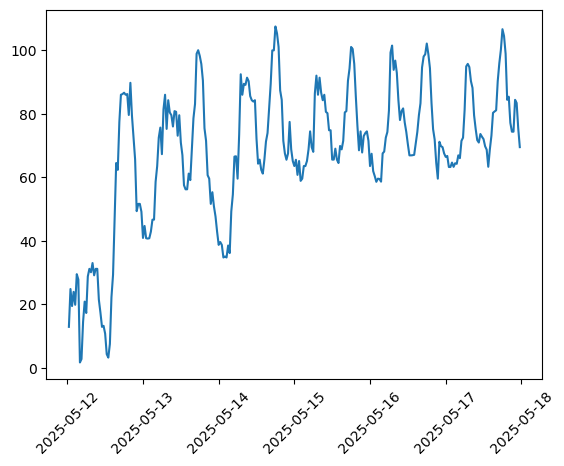

In [34]:
def plotting(s_date, e_date):
    temp = merged_df[(merged_df['Datetime'] > s_date) & (merged_df['Datetime'] < e_date)]
    plt.plot(temp.Datetime, temp.Price, linestyle = 'solid')

    plt.xticks(rotation = 45)
    plt.show()
# year, month, day    
plotting(datetime.datetime(2025,5,12), datetime.datetime(2025,5,18))
